In [14]:
import pandas as pd
import numpy as np

df = pd.read_csv("/Users/Yur/Downloads/ovitrap_data_with_province.csv", index_col=[0], usecols = ['date', 'id', 'value', 'adm'])

## Get a summary of the data per school, this makes the datacleaning more easy
    - Get schools with more than 50 observations, to have more reliable measurements
    - Filter schools with a maximum level that is less than 10 (very unlikely, probably misreporting)
    - Filter school with very high means (result of misreporting)
    - Filter schools with more than 50% 100's or 0's
    - Filter schools with only the same observations
    

In [15]:
summary_df = df.groupby(['id']).describe()

In [16]:
print(summary_df.head(5))
print(len(summary_df)) # total number of schools

   value                                                           
   count       mean        std   min     25%    50%      75%    max
id                                                                 
2   63.0  25.678889  14.678300  1.35  13.025  24.42  36.2750  62.07
3   57.0  15.087018   7.663390  0.00  11.110  15.52  20.0000  34.43
6   51.0  24.642745  14.702935  0.00  12.210  23.91  31.9450  60.26
7   88.0   6.602841   8.371931  0.00   0.000   3.18   9.3275  34.38
8   53.0  39.984528  17.904918  6.14  28.450  40.63  51.8500  74.22
12198


In [17]:
summary_df.columns = summary_df.columns.droplevel(0)

In [18]:
summary_df = summary_df[summary_df['count'] > 50] 
summary_df = summary_df[summary_df['max'] > 10] 
summary_df = summary_df[summary_df['mean'] < 90] 
summary_df = summary_df[~(((summary_df['50%']==0)|(summary_df['50%']==100)))]
summary_df = summary_df[~(summary_df['max'] == summary_df['min'])]

In [19]:
# Import full dataset, such that we can extract all the relevant schools
df = pd.read_csv("/Users/Yur/Downloads/ovitrap_data_with_province.csv", index_col=[0])
semifiltered_df = df[df['id'].isin(summary_df.index.tolist())]

# Export DataFrame to csv file
export_csv = semifiltered_df.to_csv('semi_filtered.csv') 
# S = semifiltered_df[['adm', 'id', 'value']].groupby(['adm', 'id']).describe()

## Create column that reports if a value occurs more than n (n=5) times in a row

In [20]:
# Import filtered dataset
df = pd.read_csv('semi_filtered.csv', parse_dates=['date'], usecols=['date', 'id', 'value', 'adm'])

In [21]:
i=0
sequence = np.zeros(len(df))
while i < len(df)-1:
    j = 1
    value = df.iloc[i, 2]
    value_id = df.iloc[i,1]
    next_value = df.iloc[i+j, 2]
    next_value_id = df.iloc[i+j, 1]
    
    while (next_value == value) and (next_value_id == value_id):
        next_value = df.iloc[i+j, 2]
        next_value_id = df.iloc[i+j, 1]
        j = j + 1
    
    if j > 4:
        sequence[i:(i+j-1)] = (j-1)
        i = i + j - 1
    else:
        i = i + 1
        
df['Recurring value'] = sequence

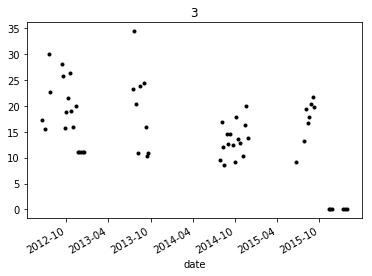

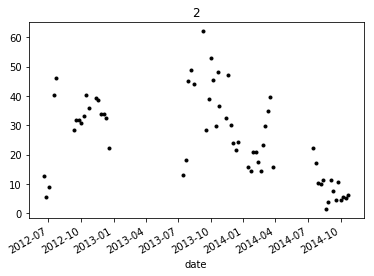

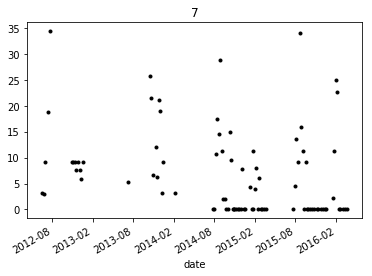

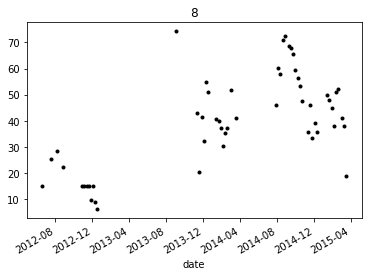

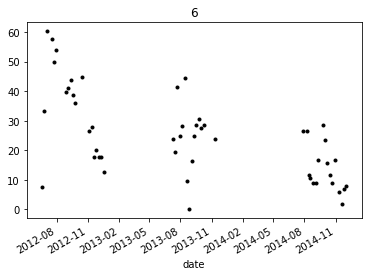

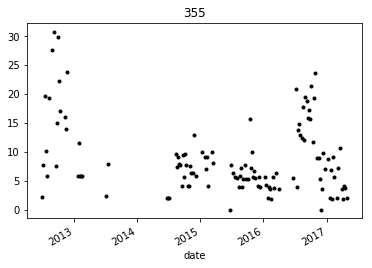

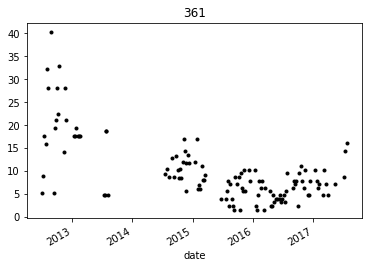

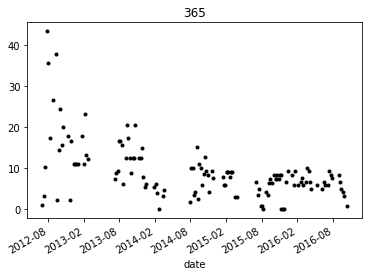

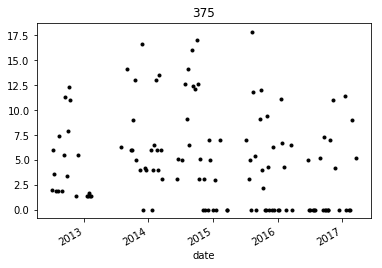

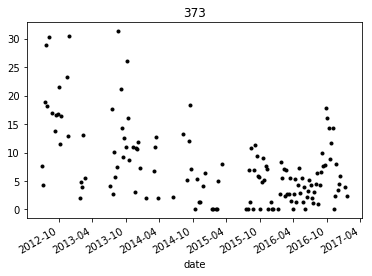

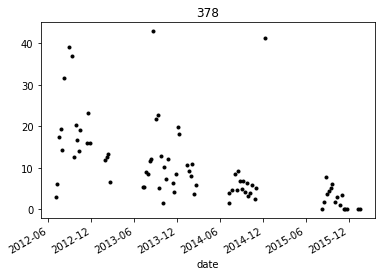

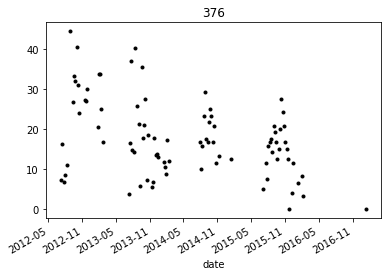

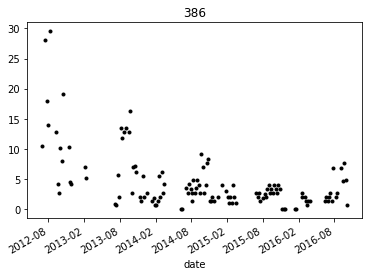

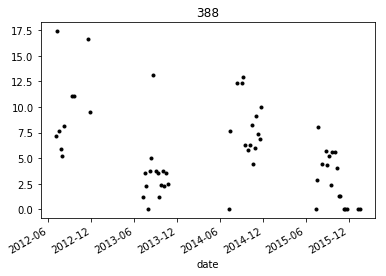

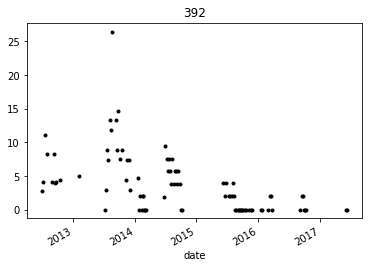

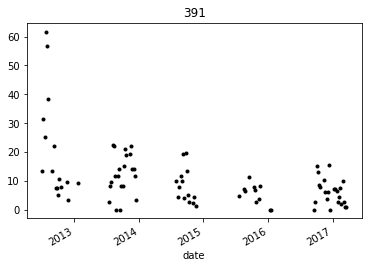

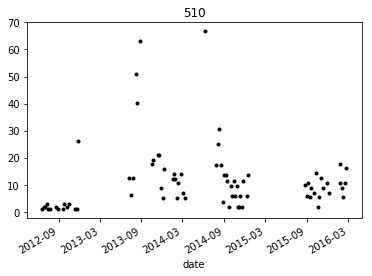

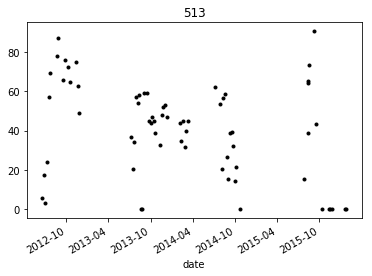

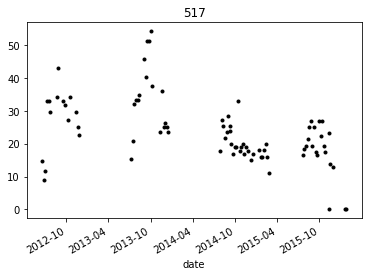

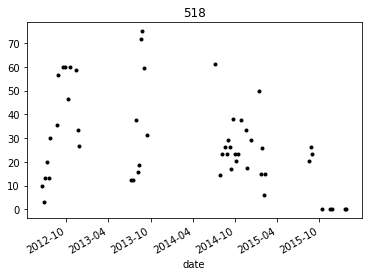

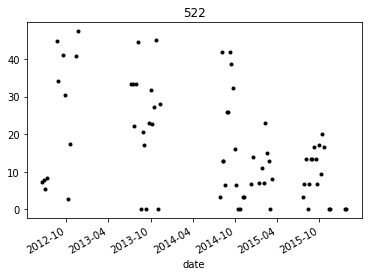

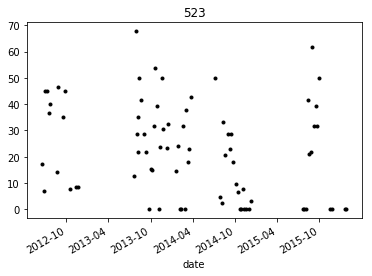

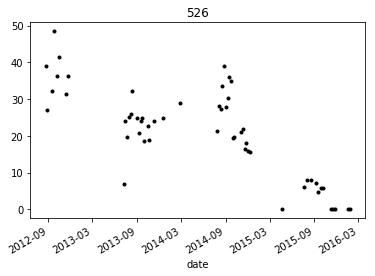

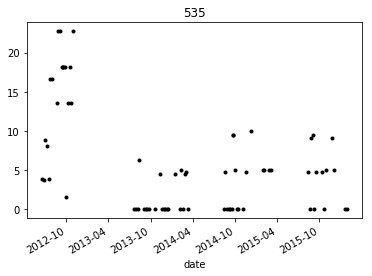

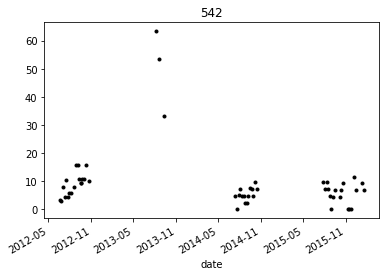

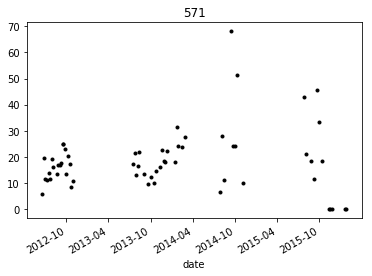

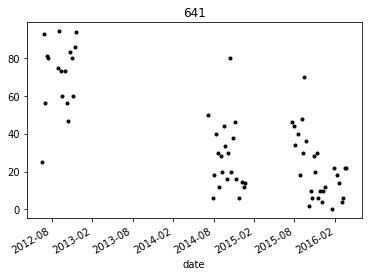

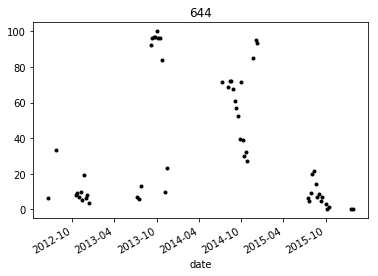

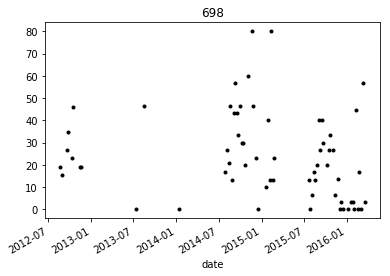

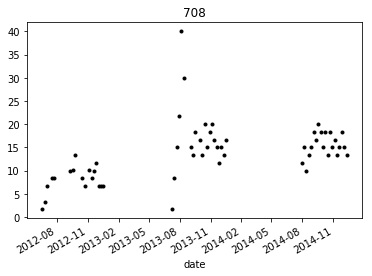

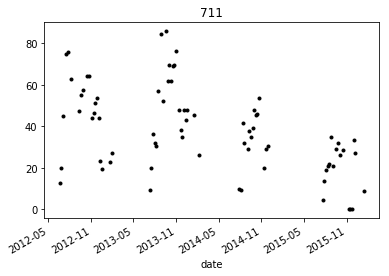

In [22]:
from matplotlib import pyplot as plt
%matplotlib inline
# Plot OviTrap index per school for a certain district

df_test = df[df['adm']=='NCR, Fourth District']
df_test = df_test.set_index(['date'])

for school in df_test['id'].unique().tolist():
    df_school = df_test[df_test['id']==school]
    df_school['value'].plot(style='k.')
    plt.title(school)
    plt.set_ylim=(0, 100)
    plt.show()

In [23]:
# List of provinces
adm_list = df['adm'].unique().tolist()

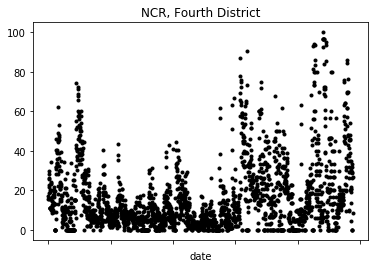

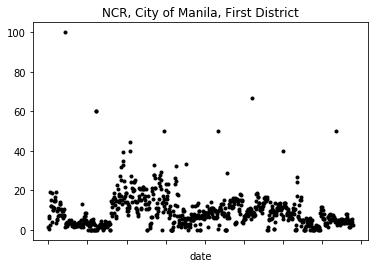

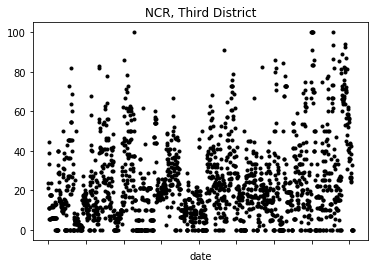

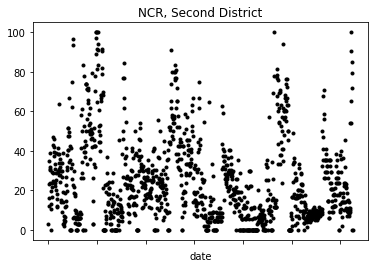

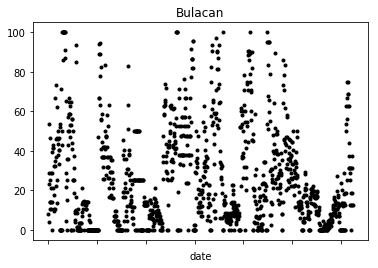

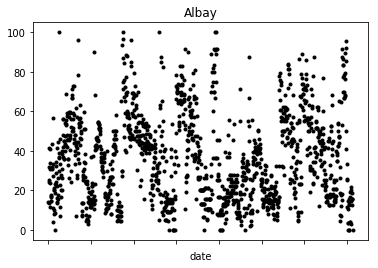

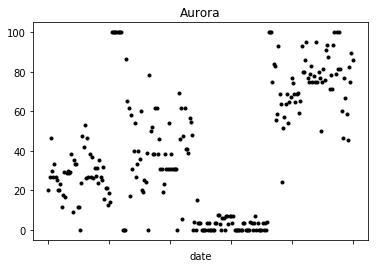

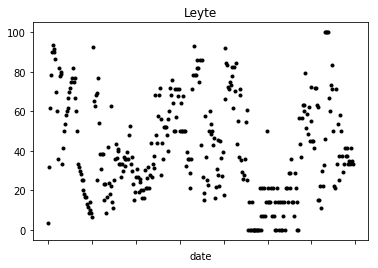

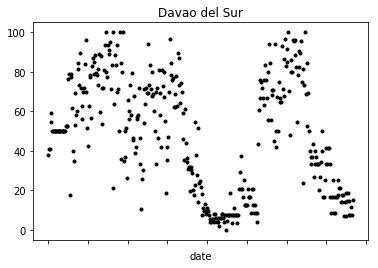

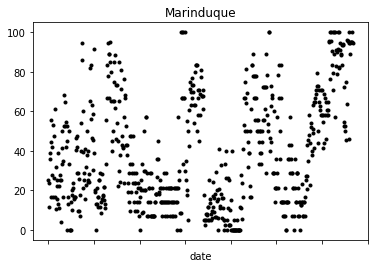

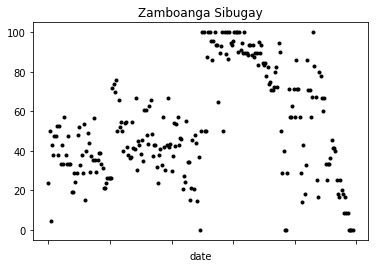

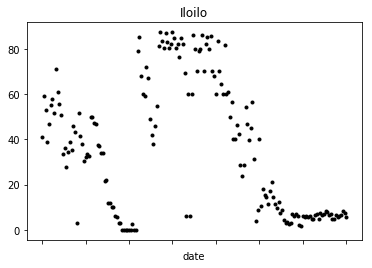

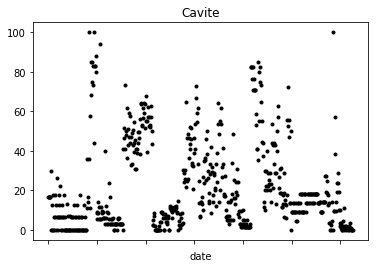

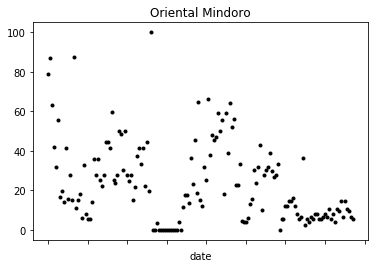

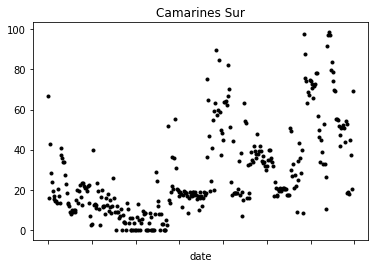

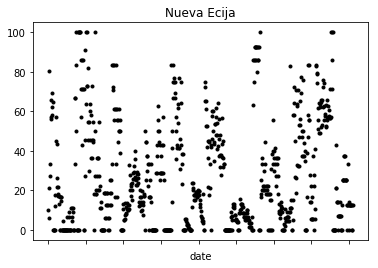

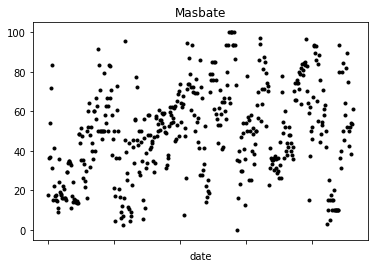

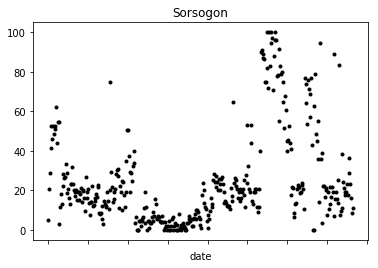

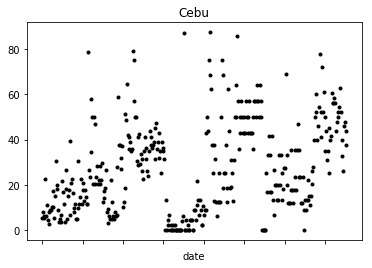

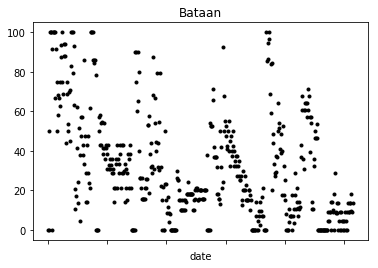

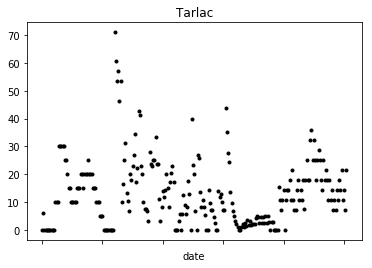

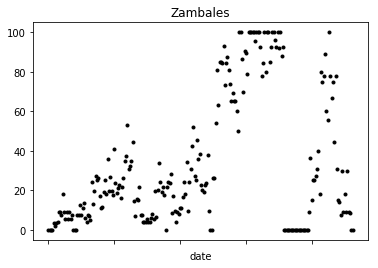

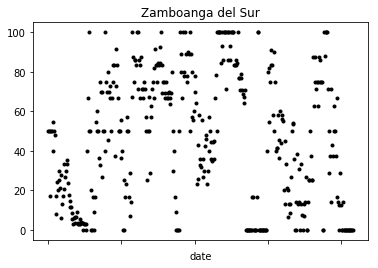

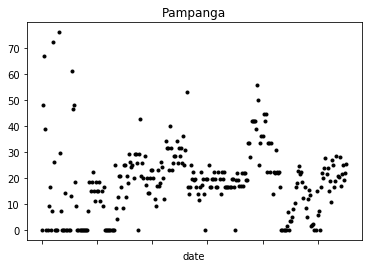

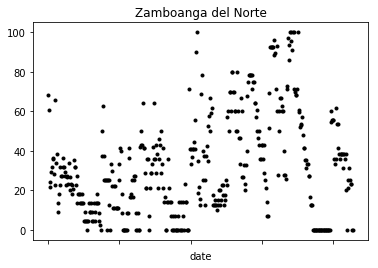

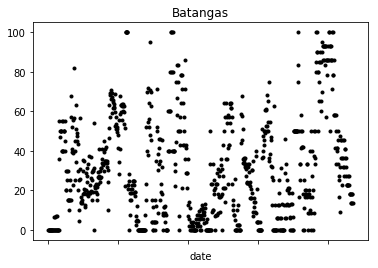

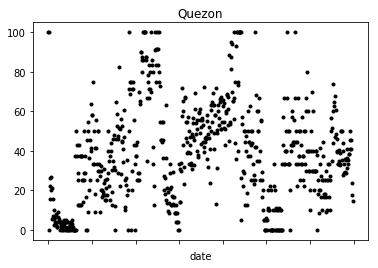

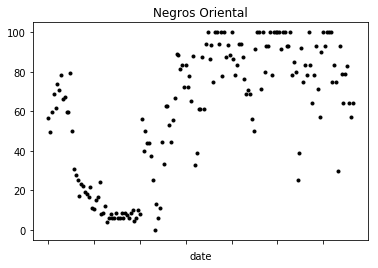

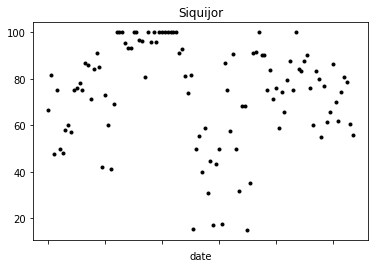

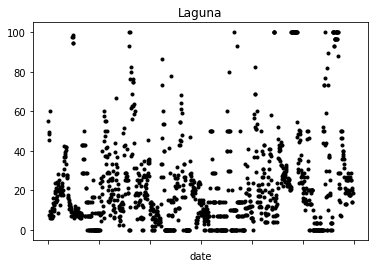

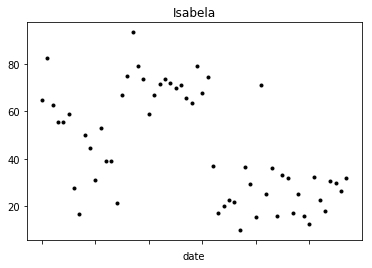

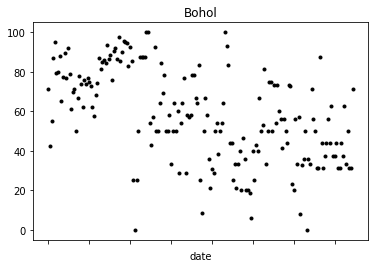

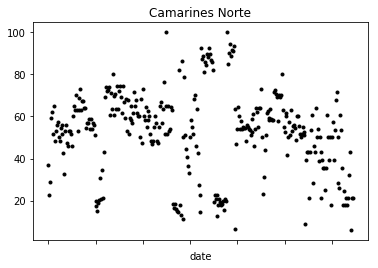

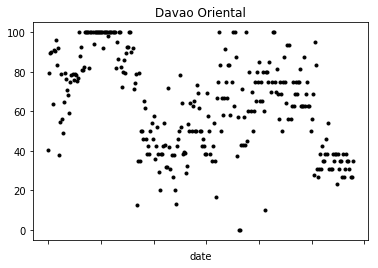

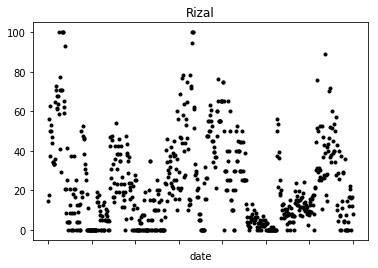

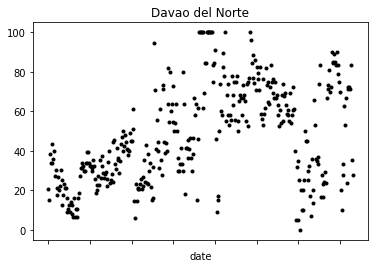

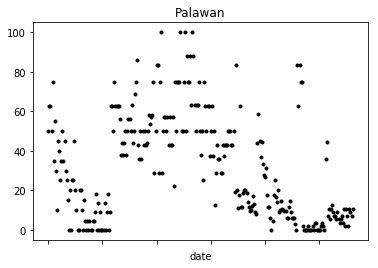

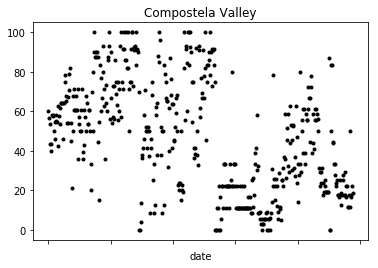

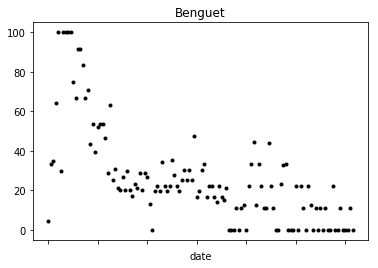

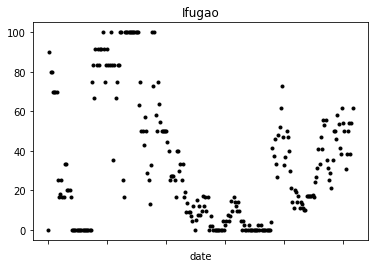

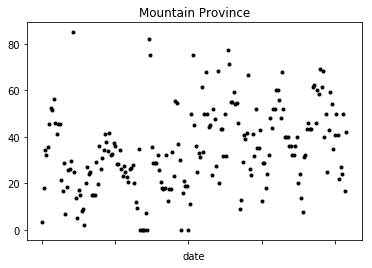

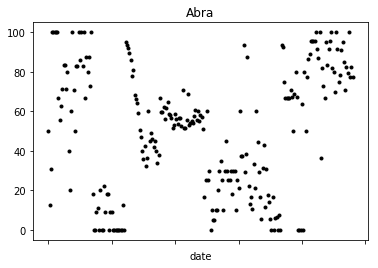

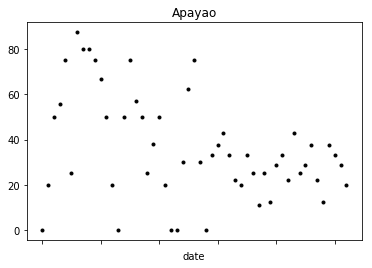

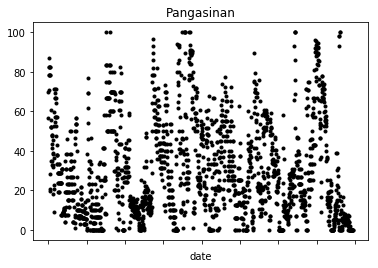

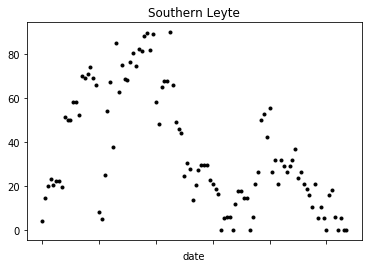

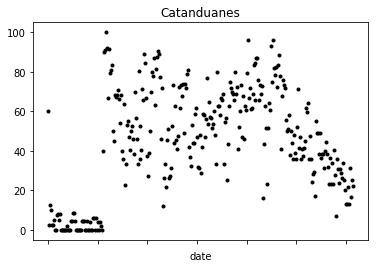

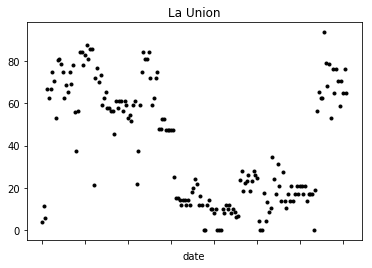

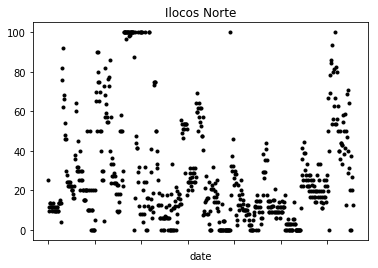

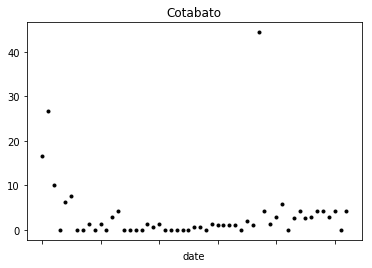

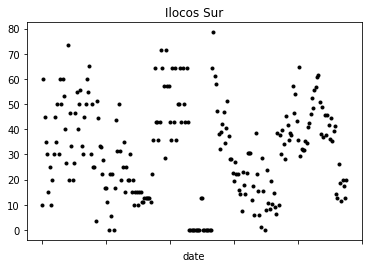

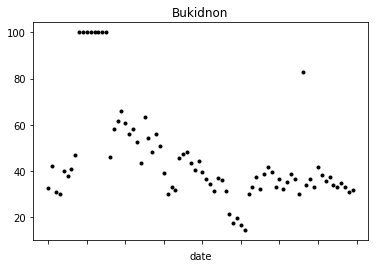

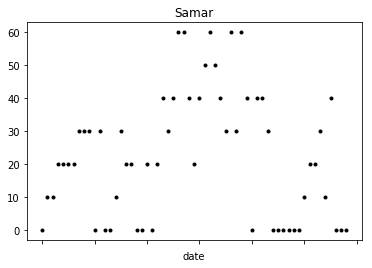

Number of missing provinces:  0


In [24]:
from matplotlib import pyplot as plt

# Plot reported OviTrap index per province, some provinces are not included and are reported as an exception

i = 0
for province in adm_list:
    df_test = semifiltered_df[semifiltered_df['adm']==province]
    df_test = df_test.set_index(['date'])
    try:
        df_test['value'].plot(style='k.')
        plt.title(province)
        plt.show()
    except:
        print("An exception occurred")
        i= i +1 
print('Number of missing provinces: ', i)

In [25]:
print(len(adm_list))

52
